### EDA

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import seaborn as sns
import plotly_express as px

Loading dataset we'll be training with:

In [2]:
train = pd.read_csv('data/train.csv.zip')

In [3]:
train.shape #4167 rows & 74 columns
train.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

As it's quite large, let's tweak pd options to dive into our dataset comfortably. This way we can display columns/rows desired with no kind of restriction.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

 ## Looking @ our target

In [10]:
train['price'].describe()

count    4167.000000
mean      168.676986
std       180.658555
min         0.000000
25%        98.000000
50%       138.000000
75%       200.000000
max      6477.000000
Name: price, dtype: float64

In [12]:
int(train['price'].max()),int(train['price'].min()) # FREE acomodations!! yay!! - probably scrape errors

(6477, 0)

In [13]:
freebies = train[train['price'] == 0] #4 free acomodations
freebies.shape

(4, 74)

## PLOTTING LOCATIONS MAP (Mapbox)

In [15]:
px.scatter_mapbox(train, lat='latitude', lon='longitude', zoom=15)

In [ ]:
train['geo'] = train['latitude'].map(str) + ‘,’ + train['longitude'].map(str)
train['geo'].sample()

In [ ]:
train['address'] = train['geo'].progress_apply(rgeocode)
train['address'].head()

## VER TEMA DE TRATAR LA CATEGORÍA GEO

Quick histplot of prices

<AxesSubplot:>

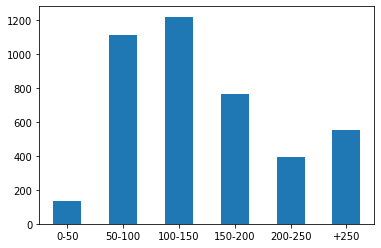

In [55]:
prices = pd.cut(train['price'],
                bins = [0, 50, 100, 150, 200, 250, train["price"].max()],
                labels=["0-50", "50-100", "100-150", "150-200", "200-250", "+250"])
 
prices.value_counts().sort_index().plot(kind="bar", rot = 0)

In [56]:
mayoria = train[train['price']<=250].shape[0]
total = train.shape[0]
mayoria/total #Casi el 87% de los precios estan por debajo de 250€

0.8682505399568035

### LOOKING @ COLUMNS

How does our df's rows look like?
Just like <code>df.head(1)</code>, but nicer ;)

In [57]:
train.sample()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
306,306,https://www.airbnb.com/rooms/45311452,20211205213126,2021-12-05,2 bedroom apartment/B&B with private roof terrace,2 bedroom on it's own private floor with private bathroom & roof t...,Quite area and close to the tourist hotspots and Westerpark. There...,https://a0.muscache.com/pictures/miso/Hosting-45311452/original/ff...,25795617,https://www.airbnb.com/users/show/25795617,Simon,2015-01-08,"Amsterdam, North Holland, Netherlands",IT Project Manager from UK who works in Amsterdam :).,within an hour,100%,97%,f,https://a0.muscache.com/im/pictures/user/d7075812-4c60-49fd-9377-2...,https://a0.muscache.com/im/pictures/user/d7075812-4c60-49fd-9377-2...,NaN,0,0,"['email', 'phone', 'google', 'reviews', 'manual_offline', 'jumio',...",t,t,"Amsterdam, Noord-Holland, Netherlands",Westerpark,NaN,52.3793,4.87599,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Hair dryer"", ""Mini fridge"", ""Iron"", ""Hangers"", ""Cooking basics"",...",118.0,3,1125,2.0,3.0,30.0,1125.0,3.0,1095.3,NaN,t,18,18,18,18,2021-12-05,10,8,0,2021-04-05,2021-10-17,4.6,4.6,4.7,4.8,4.9,4.7,4.3,0363 F5F1 A249 970C 1AD0,f,1,1,0,0,1.22


In [58]:
#train.iloc[train['id'][0]] 

NaN values

In [59]:
nan_rank = train.isna().sum() #Most to least Nans columns
nan_rank[nan_rank.values > 0].sort_values(ascending=False)

neighbourhood_group_cleansed    4167
calendar_updated                4167
bathrooms                       4167
host_neighbourhood              1786
host_about                      1512
host_response_time              1413
host_response_rate              1413
neighbourhood                   1163
neighborhood_overview           1163
host_acceptance_rate            1092
review_scores_communication      385
review_scores_location           385
review_scores_value              385
review_scores_checkin            385
review_scores_accuracy           385
review_scores_cleanliness        385
first_review                     377
last_review                      377
reviews_per_month                377
review_scores_rating             377
bedrooms                         253
beds                             174
license                           32
host_location                     12
description                        8
bathrooms_text                     8
maximum_nights_avg_ntm             1
m

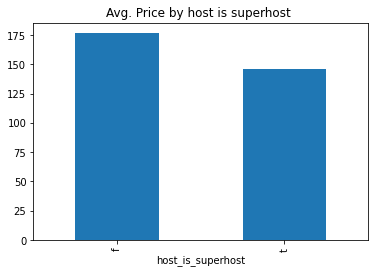

In [60]:
avg_price_superhost = train.groupby('host_is_superhost').mean()["price"]
avg_price_superhost.plot(kind="bar")
plt.title("Avg. Price by host is superhost ")
plt.show()

Al contrario de lo que podríamos esperar, el precio varía en funcion de si el host es Super o No pero
aunque de manera inversa a lo esperable

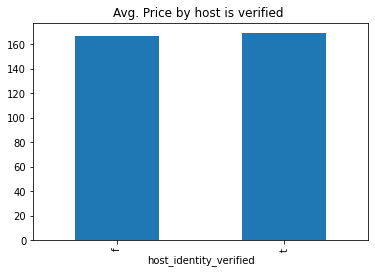

In [61]:
#plt.xticks(rotation=90)

avg_price_host_veri = train.groupby('host_identity_verified').mean()["price"]
avg_price_host_veri.plot(kind="bar")
plt.title("Avg. Price by host is verified ")
plt.show()


### ver como hacer casteo del host acceptance rate porque no me sale ni a palos

In [62]:
#train.host_acceptance_rate.astype(str)
#train.host_acceptance_rate.dtypes

#train.host_acceptance_rate = train.host_acceptance_rate.astype(str)#
#
#acc = pd.cut(train['host_acceptance_rate'],
#                bins = [0, 20, 40, 60, 80, 100],
#                labels=["0-20", "20-40", "40-60", "60-80", "80-100"])
# 
#acc.value_counts().sort_index().plot(kind="bar", rot = 0)

#avg_price_acc = train.groupby('host_acceptance_rate').mean()["price"]
#avg_price_host_veri.plot(kind="bar")
#plt.title("Avg. Price by host is verified ")
#plt.show()

In [63]:
type(train.host_acceptance_rate[0])

str

In [64]:
#CASTEO DEL HOST SINCE-->FUNCION
#train['host_since'] = train['host_since'].astype(str) #FUNCION
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y-%m-%d')

#Creo columna year_host_since
#train['host_since_year'] = pd.DatetimeIndex(train['host_since']).year
#train['host_since_year'].head()
#train = train.drop('host_since', inplace=True) # OJO QUE ESTO HAY QUE HACERLO DESPUES DE LAS TRANSFORMACIONES
#train.host_since_year.sample
#train['host_since'] = train['host_since'].astype(str)
#train['host_since'].dtypes
#train['host_since'] = pd.to_datetime(train['host_since'], format='%Y%m%d')
#train.host_since.dtype

In [65]:
selection = ['host_is_superhost',
    'host_since']

In [66]:
## host_since --> Me lo puedo cepillar o no??Es un datetime, ver como tranajarlo

## CLUSTERIZANDO LATITUDE Y LONGITUD

### CON HDBSCAN

In [67]:
#0.01 / 6378

### HABLAR CON YONA PARA VER TEMA DE MANTENER LOS GRUPOS CLUSTERIZADOS ANTERIORMENTE:

In [68]:
#latitude y longitud los vamos a clusterizar con DBSCAN: --> METIDO EN UNA FUNCION
#!pip install hdbscan

hdbscan=HDBSCAN(min_cluster_size=3,min_samples=2,cluster_selection_epsilon=0.01,
                allow_single_cluster=False,prediction_data=True,leaf_size=30)
      
#help(hdbscan)
##PARAMS
#algorithm='best', alpha=1.0, approx_min_span_tree=True,
#    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#    metric='euclidean', min_cluster_size=5, min_samples=None, p=None

Cuales son la etiquetas de HDBSCAN??

In [69]:
#train.head()

In [70]:
#test=pd.read_csv('data/test.csv.zip') #Cargamos el test para ver como clusteriza los nuevos puntos

In [71]:
#test_points = np.column_stack((test['longitude'],test['latitude']))

In [72]:
#test_labels, strengths = hdbscan.prediction.approximate_predict(clasi, test_points)
#test_labels = clasi.approximate_predict(clasi, test_points)

In [73]:
#help(clasi)

### FUNCION LIMPIEZA:

In [74]:
import funciones as f

In [75]:
train.beds.isna().sum()

174

MIRAR BIEN LO DE CATS / QUE SOLO COGE EL PRIMER
MIRAR TB LO DE LOS AMENITIES QUE ME LOS HE CEPILLADO


In [76]:
#avg_price_host_since = train.groupby('host_since_year').mean()["price"]
#avg_price_host_since.plot(kind="bar")
#plt.title("Avg. Price by host since year")
#plt.show()

# H2O

In [77]:
train_ready = f.clean(train)
train_ready.shape

(4167, 9)

In [78]:
import h2o
from h2o.automl import H2OAutoML

In [79]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=8  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,11 hours 0 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"7 days, 17 hours and 28 minutes"
H2O_cluster_name:,H2O_from_python_vp_k7rct1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.68 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [80]:
train_H2o = h2o.H2OFrame(train_ready)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [81]:
y = "price" #Target a predecir
splits = train_H2o.split_frame(ratios = [0.90], seed = 42) #Hacemos tts a pelo
train = splits[0]
test = splits[1]

In [82]:
aml = H2OAutoML(seed=1)
aml.train(y = y, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_9_20220224_112032_model_1


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 12126.974422916526
RMSE: 110.12254275540738
MAE: 52.211995196380535
RMSLE: NaN
Mean Residual Deviance: 12126.974422916526

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 21568.731075196225
RMSE: 146.8629669971168
MAE: 60.64740254461543
RMSLE: NaN
Mean Residual Deviance: 21568.731075196225

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,60.647070,2.842256,58.327286,63.643320,61.215084,62.92809,57.121580
1,mean_residual_deviance,21563.145000,24359.277000,7675.594700,64995.043000,13010.807000,11710.92900,10423.353000
2,mse,21563.145000,24359.277000,7675.594700,64995.043000,13010.807000,11710.92900,10423.353000
3,r2,0.135143,0.114194,0.272801,0.053138,0.019212,0.09035,0.240217
4,residual_deviance,21563.145000,24359.277000,7675.594700,64995.043000,13010.807000,11710.92900,10423.353000
5,rmse,133.385700,68.660390,87.610470,254.941250,114.064926,108.21704,102.094820
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-24 11:21:41,2.764 sec,0.0,226.880389,166.240287,51474.710883
1,,2022-02-24 11:21:41,2.858 sec,5.0,135.306651,55.408505,18307.889693
2,,2022-02-24 11:21:41,2.912 sec,10.0,125.370697,53.588920,15717.811643
3,,2022-02-24 11:21:41,3.142 sec,15.0,121.357037,53.413989,14727.530416
4,,2022-02-24 11:21:41,3.301 sec,20.0,117.050654,52.075398,13700.855682
5,,2022-02-24 11:21:41,3.389 sec,25.0,112.939767,52.006880,12755.390875
6,,2022-02-24 11:21:41,3.452 sec,30.0,110.122543,52.211995,12126.974423



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,host_listings_count,3.096077e+07,1.000000,0.329849
1,beds,1.954793e+07,0.631377,0.208259
2,accommodates,1.598575e+07,0.516323,0.170308
3,host_since_year,1.210132e+07,0.390860,0.128925
4,calculated_host_listings_count_entire_homes,6.839804e+06,0.220918,0.072870
5,bathroom,3.389033e+06,0.109462,0.036106
6,host_is_superhost.f,3.020288e+06,0.097552,0.032177
7,host_is_superhost.t,1.864118e+06,0.060209,0.019860
8,label_ubication,1.545295e+05,0.004991,0.001646


In [83]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid_1_AutoML_9_20220224_112032_model_1,94857.2,307.989,94857.2,73.7837,nan
XGBoost_2_AutoML_9_20220224_112032,95160.2,308.481,95160.2,72.9248,nan
XGBoost_grid_1_AutoML_9_20220224_112032_model_12,96549,310.723,96549,75.6478,nan
XGBoost_grid_1_AutoML_9_20220224_112032_model_4,97642.3,312.478,97642.3,73.5988,0.449869
XGBoost_grid_1_AutoML_9_20220224_112032_model_118,97908.4,312.903,97908.4,72.8175,0.446002
GBM_grid_1_AutoML_9_20220224_112032_model_12,98145.7,313.282,98145.7,72.856,0.441932
XGBoost_grid_1_AutoML_9_20220224_112032_model_52,98184.5,313.344,98184.5,71.6823,0.449302
GBM_grid_1_AutoML_9_20220224_112032_model_36,98234.5,313.424,98234.5,74.813,0.448928
XGBoost_grid_1_AutoML_9_20220224_112032_model_44,98336.6,313.587,98336.6,71.8114,0.43943
XGBoost_grid_1_AutoML_9_20220224_112032_model_39,98368.5,313.638,98368.5,72.6919,nan


In [84]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 94857.20678398266
RMSE: 307.9889718544849
MAE: 73.7836656080773
RMSLE: NaN
Mean Residual Deviance: 94857.20678398266


In [85]:
#ENTRENAMIENTO CON DATA SET COMPLETO
aml.leader.train(y = y, training_frame = train_H2o)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1645658382830_4


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 13605.308833999312
RMSE: 116.64179711406761
MAE: 47.70402425182847
RMSLE: NaN
Mean Residual Deviance: 13605.308833999312

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-24 12:19:56,0.022 sec,0.0,246.805956,168.177946,60913.179686
1,,2022-02-24 12:19:56,0.058 sec,1.0,203.243059,118.846580,41307.740978
2,,2022-02-24 12:19:56,0.080 sec,2.0,175.766588,86.111785,30893.893294
3,,2022-02-24 12:19:56,0.106 sec,3.0,158.352965,67.446768,25075.661389
4,,2022-02-24 12:19:56,0.125 sec,4.0,147.296087,58.528940,21696.137111
5,,2022-02-24 12:19:56,0.141 sec,5.0,140.385955,54.585623,19708.216401
6,,2022-02-24 12:19:56,0.167 sec,6.0,136.787768,53.220723,18710.893490
7,,2022-02-24 12:19:56,0.180 sec,7.0,134.572170,52.780273,18109.668912
8,,2022-02-24 12:19:56,0.213 sec,8.0,132.931694,52.627585,17670.835204
9,,2022-02-24 12:19:56,0.230 sec,9.0,130.676909,52.433128,17076.454539



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,host_listings_count,3.537421e+07,1.000000,0.245140
1,accommodates,3.269111e+07,0.924151,0.226546
2,host_is_superhost.f,3.160708e+07,0.893506,0.219034
3,beds,2.400614e+07,0.678634,0.166360
4,host_since_year,9.238556e+06,0.261166,0.064022
5,calculated_host_listings_count_entire_homes,7.966736e+06,0.225213,0.055209
6,bathroom,3.390750e+06,0.095854,0.023498
7,label_ubication,2.769730e+04,0.000783,0.000192


In [86]:
PARON

NameError: name 'PARON' is not defined

In [87]:
test = pd.read_csv('data/test.csv.zip')

In [88]:
f.clean(test)

,host_is_superhost,host_listings_count,accommodates,beds,calculated_host_listings_count_entire_homes,host_since_year,label_ubication,bathroom
0,f,1,1,1,0,2013,1,1
1,f,0,2,1,0,2019,1,1
2,f,1,2,1,1,2014,1,1
3,f,2,2,2,0,2012,1,1
4,f,0,2,1,1,2015,1,1
5,f,1,4,4,1,2014,1,1
6,f,1,4,3,1,2015,1,1
7,f,1,2,1,1,2015,1,1
8,f,1,2,1,1,2014,1,1
9,f,1,2,1,0,2013,1,1


In [89]:
testh2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [90]:
prediccion_test_completo = aml.leader.predict(testh2o)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
QUIETO

In [92]:
predict = h2o.as_list(prediccion_test_completo)
f.export(predict,'modelo7')

AttributeError: module 'funciones' has no attribute 'export'

In [ ]:
predict.to_csv(("data/{}.csv".format(nombre)))
sample = pd.read_csv('data/sample.csv')
sample.price = predict.predict  #Cambiamos columna price por la Series de Pandas que tenemos
sample.to_csv('data/modelo4_predict.csv', index = False)

In [ ]:
#Viendo los insgiths de las columnas que me da modelo 4 me puedo cepillar la mitad